# Experiment 3: CMD vs CBSD Classifier using transfer learning with Vgg16

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [26]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

In [27]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [28]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [29]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [30]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [31]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [32]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [33]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [34]:
train_dir = "data2/train/"
test_dir =   "data2/validation/"

In [35]:
model = VGG16(include_top=True, weights='imagenet')

In [36]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [37]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [38]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [39]:
batch_size = 20

In [40]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

In [41]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 1024 images belonging to 2 classes.


In [42]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 256 images belonging to 2 classes.


In [43]:

steps_test = generator_test.n / batch_size
steps_test

12.8

In [44]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [45]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [46]:
class_names = list(generator_train.class_indices.keys())
class_names

['CBSD', 'CMD']

In [47]:
num_classes = generator_train.num_class
num_classes

2

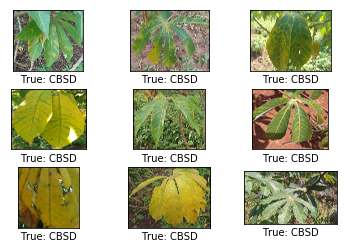

In [48]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [49]:
from sklearn.utils.class_weight import compute_class_weight

In [50]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [51]:
class_weight

array([1., 1.])

# Transfer Learning

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [53]:
transfer_layer = model.get_layer('block5_pool')

In [54]:
transfer_layer.output

<tf.Tensor 'block5_pool_2/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [55]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [56]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [57]:
optimizer = Adam(lr=1e-5)

In [58]:
loss = 'categorical_crossentropy'

In [59]:
metrics = ['categorical_accuracy']


In [60]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [61]:
print_layer_trainable()

True:	input_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [62]:
conv_model.trainable = False

In [63]:
for layer in conv_model.layers:
    layer.trainable = False

In [64]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [65]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [66]:
epochs = 20
steps_per_epoch = 5

In [67]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
5/5 [==============================] - 386s - loss: 0.8199 - categorical_accuracy: 0.5800 - val_loss: 0.7032 - val_categorical_accuracy: 0.5664
Epoch 2/20
5/5 [==============================] - 360s - loss: 0.7817 - categorical_accuracy: 0.6000 - val_loss: 0.6971 - val_categorical_accuracy: 0.5273
Epoch 3/20
5/5 [==============================] - 358s - loss: 0.6453 - categorical_accuracy: 0.6500 - val_loss: 0.6887 - val_categorical_accuracy: 0.5508
Epoch 4/20
5/5 [==============================] - 358s - loss: 0.6152 - categorical_accuracy: 0.6300 - val_loss: 0.6817 - val_categorical_accuracy: 0.6406
Epoch 5/20
5/5 [==============================] - 359s - loss: 0.5676 - categorical_accuracy: 0.7000 - val_loss: 0.6777 - val_categorical_accuracy: 0.6328
Epoch 6/20
5/5 [==============================] - 358s - loss: 0.4506 - categorical_accuracy: 0.7400 - val_loss: 0.6876 - val_categorical_accuracy: 0.5859
Epoch 7/20
5/5 [==============================] - 358s - loss: 0.5680 

In [68]:
'''from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.compile(optimizer='adam', loss=loss, metrics=metrics)
# load weights into new model
loaded_model.load_weights("model1.h5")
print("Loaded model from disk")'''

'from keras.models import model_from_json\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\nloaded_model.compile(optimizer=\'adam\', loss=loss, metrics=metrics)\n# load weights into new model\nloaded_model.load_weights("model1.h5")\nprint("Loaded model from disk")'

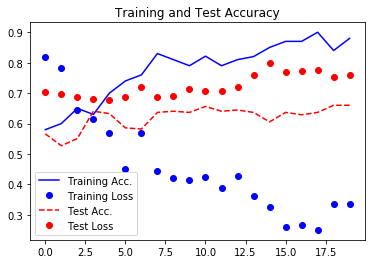

In [69]:
plot_training_history(history)

In [70]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [71]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 66.02%


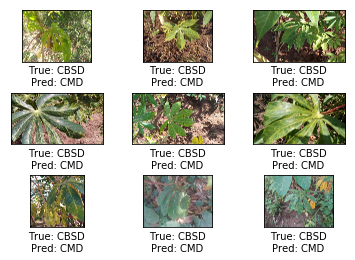

Confusion matrix:
[[77 51]
 [36 92]]
(0) CBSD
(1) CMD


In [72]:
example_errors()

In [73]:
from keras.models import load_model
new_model.save('models/cmdvcbsd_model.h5')

Using TensorFlow backend.


# Saving the weights and model as Json

In [1]:
new_model.save_weights('models/cmdvcbsd_weights.h5')

# Save the model architecture
with open('models/cmdvcbsd_architecture.json', 'w') as f:
    f.write(model.to_json())

NameError: name 'new_model' is not defined